In [1]:
import os

# CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import pickle
import clip
import socket
import numpy as np
import torch
from utils import nethook

%reload_ext autoreload
%autoreload 2

print("Hostname: " + socket.gethostname())
print("Torch version:", torch.__version__)
torch.cuda.empty_cache()

Hostname: sx-el-121920
Torch version: 1.13.0a0+d0d6b1f


In [3]:
# model parameters
USE_BIASED_STANDALONE_MODEL = False

# general configuration
ROOT_PATH = "/mnt/data/patrick.koller/masterthesis/data"

# simplify problem
USE_ALL_STANDALONE_LAYERS = True
USE_ALL_CLIP_LAYERS = False
LIMIT_NR_LAYERS = 100 # Active, if all layers are used with the configurations above = True

# dataset parameters
DATASET_SPLIT = 'test' # 'train', 'test', 'test_fool'
DATASET_COLOR = False
DATASET_BATCH_SIZE = 25
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

# general parameters
RECOMPUTE_EVERYTHING = True

# reasonable test scenarios
# 1. Biased model with color images testset (train/validation/test)
# 2. Unbiased model with grayscale images testset (train/validation/test)

In [4]:
if USE_BIASED_STANDALONE_MODEL:
    STANDALONE_PATH = f"{ROOT_PATH}/results/standalone_biased"
else:
    STANDALONE_PATH = f"{ROOT_PATH}/results/standalone_unbiased"

# set device (for number crunching)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load standalone model

In [6]:
def setup_standalone(all_layers=True, all_layers_limit=100, print_config=False):

    # load model
    if USE_BIASED_STANDALONE_MODEL:
        standalone_model = pickle.load(open(f"{STANDALONE_PATH}/standalone_resnet50_biased.mdl", 'rb'))
    else:
        standalone_model = pickle.load(open(f"{STANDALONE_PATH}/standalone_resnet50_unbiased.mdl", 'rb'))
    standalone_model.cuda()

    # make sure that all standalone resnet50 parameters are floating point variables (paranoia)
    for p in standalone_model.parameters(): 
        p.data = p.data.float()  
        
    # save layers to be swapped
    if all_layers:
        standalone_layers = []
        counter = 0

        for name, layer in standalone_model.named_modules():
            if "conv" in name and counter < all_layers_limit:
                standalone_layers.append(name)
                counter += 1
        del counter
    else:
        # standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3']
        standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1']
        # standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1', 'layer1.1.conv2']
        
    # additional info
    if print_config:       
        print(f"Number of standalone layers: {len(standalone_layers)}")
        print(standalone_layers)

    # hook layers for standalone model
    standalone_model.eval()
    standalone_model = nethook.InstrumentedModel(standalone_model)
    standalone_model.retain_layers(standalone_layers)

    return standalone_model, standalone_layers

standalone_model, standalone_layers = setup_standalone(USE_ALL_STANDALONE_LAYERS, LIMIT_NR_LAYERS, print_config=True)

Number of standalone layers: 49
['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3', 'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3']


# load CLIP model

In [7]:
def setup_clip(all_layers=True, all_layers_limit=100, print_config=False):
    
    # load model
    clip_model, clip_preprocess = clip.load("RN50")
    clip_model.cuda().eval()

    # make sure that all clip parameters are floating point variables (paranoia)
    for p in clip_model.parameters(): 
        p.data = p.data.float() 
        
    # save layers to be swapped
    if all_layers:
        clip_layers = []
        counter = 0

        for name, layer in clip_model.named_modules():
            if "conv" in name and counter < all_layers_limit:
                clip_layers.append(name)
                counter += 1
        del counter
    else:
        clip_layers = ["visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
        # clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3']
        # clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3', 'visual.layer1.1.conv1', 'visual.layer1.1.conv2', 'visual.layer1.1.conv3']
    
    # additional info
    if print_config:       
        print(f"Number of CLIP layers: {len(clip_layers)}")
        print(clip_layers)

    # hook layers for clip model
    clip_model.eval()
    clip_model = nethook.InstrumentedModel(clip_model)
    clip_model.retain_layers(clip_layers)
    
    return clip_model, clip_preprocess, clip_layers

clip_model, clip_preprocess, clip_layers = setup_clip(USE_ALL_CLIP_LAYERS, LIMIT_NR_LAYERS, print_config=True)

Number of CLIP layers: 4
['visual.layer1', 'visual.layer2', 'visual.layer3', 'visual.layer4']


# load datasets

In [8]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

MNIST dataset already exists
Number of samples: 2000


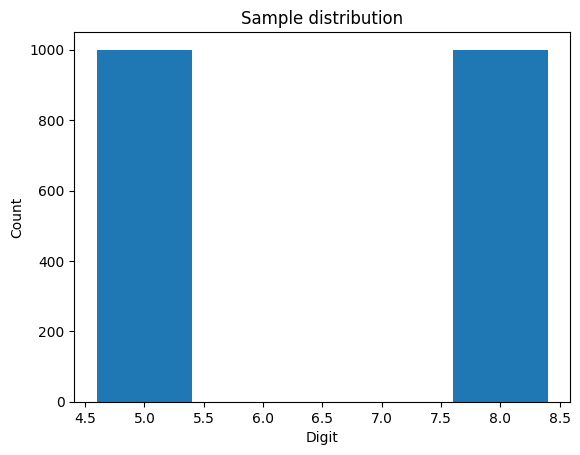

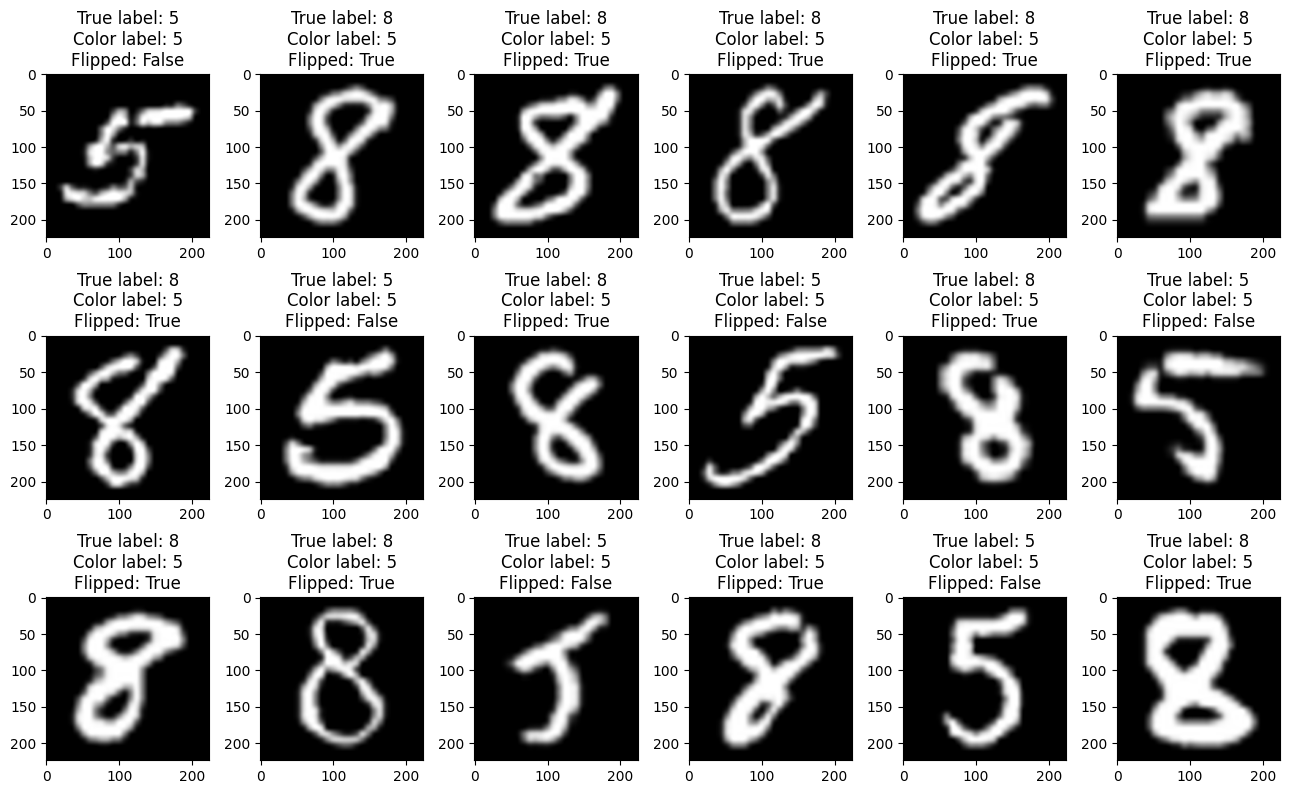

In [9]:
from torchvision import transforms

# initialize dataset
data_set = DatasetMNIST(root=ROOT_PATH,
                        env=DATASET_SPLIT,
                        color=DATASET_COLOR,
                        opt_postfix="2classes",
                        filter=[5,8],
                        first_color_max_nr=5,
                        preprocess=clip_preprocess,
                        test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                        transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

if RECOMPUTE_EVERYTHING:
    print(f"Number of samples: {len(data_loader.dataset.data_label_tuples)}")
    digit_distribution(data_set)
    plot_digits(data_set, clip_preprocess)

# compute statistics

In [10]:
from torchvision import transforms

def get_mean_std(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, device):
    print("Collecting Dataset Statistics")
    
    standalone_model_stats_list = []
    clip_model_stats_list = []
    
    # batch processing
    with torch.no_grad():
        for iteration, data in enumerate(dataloader):
            
            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            ###############################################################################
            # Compute activations and statistics for standalone model
            ###############################################################################
            
            # inference
            _ = standalone_model(inputs)

            # store activations from current batch
            standalone_model_activations = {}
            for layer in standalone_layers:
                standalone_model_activations[layer] = []    
                standalone_model_activation = standalone_model.retained_layer(layer, clear = True)
                standalone_model_activations[layer].append(standalone_model_activation)
            
            # compute statistics (mean and standard deviation)
            batch_standalone_model_stats_list = []
            for layer in standalone_layers:
                standalone_model_activations[layer] = torch.cat(standalone_model_activations[layer], 0) # images x channels x m x m
                standalone_model_activations[layer] = torch.permute(standalone_model_activations[layer], (1,0,2,3)).contiguous() # channels x images x m x m
                standalone_model_activations[layer] = standalone_model_activations[layer].view(standalone_model_activations[layer].shape[0], -1) 
                batch_standalone_model_stats_list.append([torch.mean(standalone_model_activations[layer],dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(standalone_model_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del standalone_model_activations
            standalone_model_stats_list.append(batch_standalone_model_stats_list)

            ###############################################################################
            # Compute activations and statistics for clip model
            ###############################################################################

            # inference
            _ = clip_model.model.encode_image(inputs)

            # store activations from current batch
            clip_model_activations = {}
            for layer in clip_layers:
                clip_model_activations[layer] = []    
                clip_model_activation = clip_model.retained_layer(layer, clear = True)
                clip_model_activations[layer].append(clip_model_activation)

            # compute statistics (mean and standard deviation)
            batch_clip_model_stats_list = []
            clip_model_stats_list.append(batch_clip_model_stats_list)
            for layer in clip_layers:
                clip_model_activations[layer] = torch.cat(clip_model_activations[layer], 0)
                clip_model_activations[layer] = torch.permute(clip_model_activations[layer], (1,0,2,3)).contiguous()
                clip_model_activations[layer] = clip_model_activations[layer].view(clip_model_activations[layer].shape[0], -1)
                batch_clip_model_stats_list.append([torch.mean(clip_model_activations[layer], dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(clip_model_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del clip_model_activations
            torch.cuda.empty_cache()
            
        print("Done Iteration for Stats")

        ###############################################################################
        # All batches processed, create final statistics
        ###############################################################################
        # compute final stats for standalone model
        final_standalone_model_stats_list = []

        for iii in range(len(batch_standalone_model_stats_list)):
            means = torch.zeros_like(batch_standalone_model_stats_list[iii][0])
            stds = torch.zeros_like(batch_standalone_model_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=standalone_model_stats_list[jjj][iii][0]
                stds+=standalone_model_stats_list[jjj][iii][1]**2

            final_standalone_model_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])
        del batch_standalone_model_stats_list
        
        # compute final stats for clip model
        final_clip_model_stats_list = []

        for iii in range(len(batch_clip_model_stats_list)):
            means = torch.zeros_like(batch_clip_model_stats_list[iii][0])
            stds = torch.zeros_like(batch_clip_model_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=clip_model_stats_list[jjj][iii][0]
                stds+=clip_model_stats_list[jjj][iii][1]**2

            final_clip_model_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])
        del batch_clip_model_stats_list

    return final_standalone_model_stats_list, final_clip_model_stats_list

In [11]:
def save_array(array, filename):
    """
    Save array to disk.
    """
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [12]:
def store_activs(model, layers):
    """
    Create list of retained activations for each layer.
    """
    activs = []
    for layer in layers:
        activation = model.retained_layer(layer, clear = True)
        activs.append(activation)
        
    return activs

In [13]:
def dict_layers(activs):
    """
    Create dictionary with activations of a layer as keys and the number of kernels in this layer as values.
    """
    all_layers = {}
    for iii, activ in enumerate(activs):
        all_layers[activs[iii]] = activ.shape[1]
    return all_layers

In [14]:
def normalize(activation, stats_table):
    """
    Normalize activations using standard scaling.
    """
    eps = 0.00001
    norm_input = (activation- stats_table[0])/(stats_table[1]+eps)
    
    return norm_input

In [15]:
def create_final_table(all_match_table, standalone_dict, clip_dict, batch_size, device ):
    """
    "Flatten" 4D-tensor all_match_table to large 2D-tensor final_match_table
    for better indexing and usability.
    """
    
    # create empty table of size: "number of convolution kernels in standalone_dict" x "number of convolution kernels in clip_dict"
    num_activs_standalone = sum(standalone_dict.values())
    num_activs_clip = sum(clip_dict.values())
    final_match_table = torch.zeros((num_activs_standalone, num_activs_clip)).to(device)
    
    # "flatten" 4D-tensor to large 2D-tensor
    standalone_activ_count = 0 
    for ii in range(len(all_match_table)):
        clip_activ_count = 0
        for jj in range(len(all_match_table[ii])):
            num_standalone_activs = all_match_table[ii][0].shape[0]
            num_clip_activs = all_match_table[0][jj].shape[1]
            final_match_table[standalone_activ_count: standalone_activ_count + num_standalone_activs, \
                clip_activ_count:clip_activ_count + num_clip_activs] = all_match_table[ii][jj]
            clip_activ_count += num_clip_activs
        standalone_activ_count += num_standalone_activs
    return final_match_table

# activation matching

In [16]:
from utils import matching, nethook, stats

def activation_matching(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, save_path, device):
    
    # compute dataset statistics
    standalone_model_statistics_table, clip_model_statistics_table = get_mean_std(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, device)
    save_array(standalone_model_statistics_table, f"{save_path}/standalone_model_statistics.pkl")
    save_array(clip_model_statistics_table, f"{save_path}/clip_model_statistics.pkl")
    
    print("Done")
    print("Starting Activation Matching")
    
    for iteration, data in enumerate(dataloader):
        with torch.no_grad():

            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            # inference standalone model
            _ = standalone_model(inputs)
            
            # append standalone model layer-activations for each layer
            standalone_model_activations = store_activs(standalone_model, standalone_layers)

            # inference clip model
            _ = clip_model.model.encode_image(inputs)
            del inputs

            # append clip model layer-activations for batch
            clip_model_activations =  store_activs(clip_model, clip_layers)

            # create dictionary of activations in layers and number of activations
            all_standalone_layers = dict_layers(standalone_model_activations)
            all_clip_layers = dict_layers(clip_model_activations)
            
            # create empty table of size: "number of convolution kernels in standalone model" x "number of convolution kernels in clip model"
            if iteration == 0:
                num_standalone_model_activations = sum(all_standalone_layers.values())
                num_clip_model_activations = sum(all_clip_layers.values())
                final_match_table = torch.zeros((num_standalone_model_activations, num_clip_model_activations)).to(device)

            # matching
            all_match_table = []

            for ii, standalone_model_activation in enumerate(standalone_model_activations):
                match_table = []
                standalone_model_activation = normalize(standalone_model_activation, standalone_model_statistics_table[ii])

                for jj, clip_model_activation in enumerate(clip_model_activations):
                    clip_model_activation_scaled = normalize(clip_model_activation, clip_model_statistics_table[jj]) 
                    # scale maps to same size
                    map_size = max((standalone_model_activation.shape[2], clip_model_activation.shape[2]))
                    standalone_model_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(standalone_model_activation)
                    clip_model_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(clip_model_activation_scaled)
                    # einsum(..) sums the product of the elements of the input -> Checkout einsum notebook
                    scores = torch.einsum('aixy,ajxy->ij', standalone_model_activation_scaled, clip_model_activation_scaled)/(batch_size*map_size**2)  
                    scores = scores.cpu()
                    
                    match_table.append(scores)
                    del standalone_model_activation_scaled
                    del clip_model_activation_scaled
                    del scores
                    
                all_match_table.append(match_table)
                del match_table

            # create table
            batch_match_table = create_final_table(all_match_table, all_standalone_layers, all_clip_layers, batch_size, device)
            final_match_table += batch_match_table
            save_array(final_match_table, f"{save_path}/norm_table_"+str(iteration)+".pkl")

            # cleanup
            del all_match_table
            del batch_match_table
            del standalone_model_activations
            del clip_model_activations
            torch.cuda.empty_cache()
            
    # average and save
    final_match_table /= len(dataloader)
    save_array(final_match_table, f"{save_path}/table.pkl")
    del final_match_table
    

In [17]:
import time

start_time = time.time()

if RECOMPUTE_EVERYTHING:
    activation_matching(standalone_model, standalone_layers,
                        clip_model, clip_layers,
                        dataloader=data_loader,
                        batch_size=DATASET_BATCH_SIZE,
                        save_path=STANDALONE_PATH,
                        device=device)   

end_time = time.time()

print(f"Runtime: {np.round(end_time - start_time, 3)}s")

Batch 0 is being processed...
Batch 1 is being processed...
Batch 2 is being processed...
Batch 3 is being processed...
Batch 4 is being processed...
Batch 5 is being processed...
Batch 6 is being processed...
Batch 7 is being processed...
Batch 8 is being processed...
Batch 9 is being processed...
Batch 10 is being processed...
Batch 11 is being processed...
Batch 12 is being processed...
Batch 13 is being processed...
Batch 14 is being processed...
Batch 15 is being processed...
Batch 16 is being processed...
Batch 17 is being processed...
Batch 18 is being processed...
Batch 19 is being processed...
Batch 20 is being processed...
Batch 21 is being processed...
Batch 22 is being processed...
Batch 23 is being processed...
Batch 24 is being processed...
Batch 25 is being processed...
Batch 26 is being processed...
Batch 27 is being processed...
Batch 28 is being processed...
Batch 29 is being processed...
Batch 30 is being processed...
Batch 31 is being processed...
Batch 32 is being 

In [18]:
from pynvml import *
import gc

# gc.collect()
torch.cuda.empty_cache()

nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 34089730048
free     : 325320704
used     : 33764409344


In [19]:
def load_stats(root, device):
    """
    Load statistics about the standalone and CLIP models. The function
    returns the statistics for each model and the score table, which
    describes which kernels are most similar between the two models
    in terms of their standard scaled activations.
    """

    # load table
    file_name = os.path.join(root, "table.pkl")
    with open(file_name, 'rb') as f:
        table = pickle.load(f)
        table = table.to(device)
    
    # load statistics from standalone model
    with open(os.path.join(root,"standalone_model_statistics.pkl"), 'rb') as f:
        standalone_statistics = pickle.load(f)
        for iii, item1 in enumerate(standalone_statistics):
            for jjj, item2 in enumerate(standalone_statistics[iii]):
                standalone_statistics[iii][jjj] = standalone_statistics[iii][jjj].to(device)
                
    # load statistics from clip model
    with open(os.path.join(root,"clip_model_statistics.pkl"), 'rb') as f:
        clip_statistics = pickle.load(f)
        
        for iii, item1 in enumerate(clip_statistics):
            for jjj, item2 in enumerate(clip_statistics[iii]):
                clip_statistics[iii][jjj] = clip_statistics[iii][jjj].to(device)
        
    return table, standalone_statistics, clip_statistics

In [20]:
table, standalone_statistics, clip_statistics = load_stats(STANDALONE_PATH, device)
# table, standalone_statistics, clip_statistics = load_stats(f"/mnt/data/patrick.koller/masterthesis/data/results/backup/results", device)


########################################
# table
########################################
# number of kernels in standalone model x number of kernels in clip model
# and therefore, since every kernel results in one activation/feature map:
# num_standalone_model_activations x num_clip_model_activations
print(f"{table.shape=}")


########################################
# Standalone statistics
########################################
# len(standalone_statistics) = 49 conv layers
# len(standalone_statistics[0]) = 2 => Choose between mean [0] or std [1]
# standalone_statistics[0][0].shape = torch.Size([1, 64, 1, 1]) => 64 activations maps of the 64 conv kernels in first layer

nr_feature_maps_standalone = 0

for i in range(len(standalone_statistics)):
    nr_feature_maps_standalone += standalone_statistics[i][0].shape[1]
    
print(f"Number of feature maps in standalone model:{nr_feature_maps_standalone}")


########################################
# CLIP statistics
########################################
# for all layers:
# len(clip_statistics) = 51 conv layers
# len(clip_statistics[0]) = 2 => Choose between mean [0] or std [1]
# clip_statistics[0][0].shape = torch.Size([1, 32, 1, 1]) => 32 activations maps of the 32 conv kernels in first layer
#
# for last layer of the last four stages:
# len(clip_statistics) = 4 conv layers
# len(clip_statistics[0]) = 2 => Choose between mean [0] or std [1]
# clip_statistics[0][0].shape = torch.Size([1, 256, 1, 1]) => 256 activations maps of the 256 conv kernels in last layer of second stage
nr_feature_maps_clip = 0

for i in range(len(clip_statistics)):
    nr_feature_maps_clip += clip_statistics[i][0].shape[1]
    
print(f"Number of feature maps in CLIP image-encoder:{nr_feature_maps_clip}")

table.shape=torch.Size([22720, 3840])
Number of feature maps in standalone model:22720
Number of feature maps in CLIP image-encoder:3840


In [21]:
# find highest scores between standalone to clip kernels
# (max possible index is equal to nr_feature_maps_standalone=22'720)
# dim=0 searches max along the columns (vertical direction)
# dim=1 searches max along the rows (horizontal direction)
# (dim does not influence match_scores, but clip_idxs)
match_scores, standalone_idxs = torch.max(table, dim=0)
# same output as:
# clip_idxs = torch.argmax(table, dim=1)
# match_scores, _ = torch.max(table, dim=1)

In [22]:
# sanity checks
print(f"Smallest index in standalone model to be swapped is {standalone_idxs.min()}")
print(f"Largest index in standalone model to be swapped is {standalone_idxs.max()}")
print(f"{standalone_idxs.unique().shape[0]} unique kernels to be swapped out of {standalone_idxs.shape[0]}")

Smallest index in standalone model to be swapped is 0
Largest index in standalone model to be swapped is 22719
1535 unique kernels to be swapped out of 3840


In [23]:
# poor man's moving average
WINDOW=42

averaged_signal = []

for i in range(WINDOW):
    averaged_signal.append(0)

for i in range(standalone_idxs.cpu().numpy().shape[0] - WINDOW):
    asdf = standalone_idxs.cpu().numpy()[i:i+WINDOW].sum()/WINDOW
    averaged_signal.append(asdf)

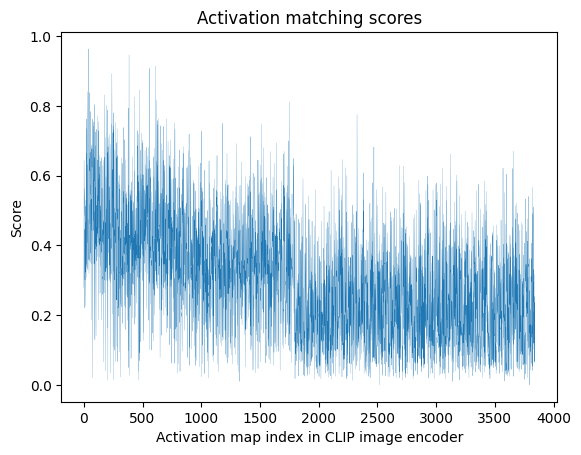

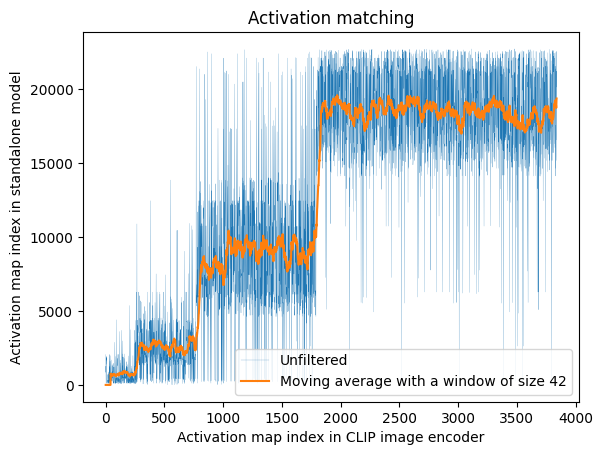

In [24]:
# plots
if RECOMPUTE_EVERYTHING:
    plt.plot(match_scores.cpu().numpy(), linewidth=.15)
    plt.title("Activation matching scores")
    plt.xlabel("Activation map index in CLIP image encoder")
    plt.ylabel("Score")
    plt.show()

    plt.plot(standalone_idxs.cpu().numpy(), label='Unfiltered', linewidth=.15)
    plt.plot(averaged_signal, label=f'Moving average with a window of size {WINDOW}')
    plt.title("Activation matching")
    plt.xlabel("Activation map index in CLIP image encoder")
    plt.ylabel("Activation map index in standalone model")
    plt.legend()
    plt.show()

# layer swapping

In [25]:
def find_act(act_num, net_dict):
    """
    Finding the index of the layer and the local index of a unit within that layer,
    if all kernels within a model are stacked and the absolut index of the unit is 
    given.
    """
    layers_list = list(net_dict)
    
    layer = 0
    counter = 0
    
    while act_num >= counter:
        layer += 1
        counter += net_dict[layers_list[layer - 1]]
        
    act = act_num-counter + net_dict[layers_list[layer - 1]]
    
    del layers_list
    torch.cuda.empty_cache()
    
    return (layer - 1), act

In [ ]:
def resize_and_stack(curr_layer, table, clip_activs, standalone_activs, all_standalone_layers, idxs, k):
    """
    Resize kernels from standalone model to the size of the kernels in clip model.
    
    resize_and_stack is invoked for every CLIP layer once.
    
    curr_layer                # index of CLIP layer
    table                     # matching scores 22'720x3'840
    clip_activs[i],           # CLIP activations [1, 256, 56, 56] of CLIP layer i (1 denotes the one and only image in this batch)
    standalone_activs,        # list of all standalone activations 49 x [1, #kernels, kernelheight, kernelwidth]
    all_standalone_layers,    # dict of standalone layers with activations as keys and #kernels in layers as values
    match_idxs,               # standalone kernel indexes (with highest scores) to be swapped with kernels in CLIP layer i
    k = 0)                    # not used! Will be computed in this function. (Replace all units of a layer)
    """
    
    # scores = match_scores[idxs]
    map_size = clip_activs.shape[2] # kernelwidth/kernelheight -> is equal to clip_activs.shape[3]
    standalone_activ_matches = torch.zeros_like(clip_activs)
    
    for i, idx in enumerate(idxs):
        clip_act_name = find_act(idx, all_standalone_layers)                                            # find layer and unit of this standalone unit to be swapped to CLIP
        activ = standalone_activs[clip_act_name[0]][:, clip_act_name[1], :, :].unsqueeze(0)             # activations of unit to be swapped
        activ = torch.nn.functional.interpolate(activ, size = (map_size, map_size), mode = "bicubic")   # upscale
        standalone_activ_matches[:, i, :, :] = activ
        
    # print(f"{idxs.shape=} - before")
    # print(f"{idxs.max()=} - before\n")
    
    # compute per-channel correlation between CLIP and standalone activations to rank feature alignment
    scores = torch.einsum('aixy,aixy->ai', clip_activs, standalone_activ_matches) / (map_size**2)
    k = standalone_activ_matches.shape[1]
    vals, idxs = torch.topk(scores, k=k)
    
    # idxs = idxs.unsqueeze(dim=0)
    
    # print(f"{idxs.shape=} - after")
    # print(f"{idxs.max()=} - after\n")
    
    # print("CLIP layer" + str(curr_layer) + ": Replace " + str(k) + " units.")
    
    return standalone_activ_matches, idxs

In [27]:
def swap_activs(clip_model, cliplayer_name, standalone_activ, idx, clip_stats):
    """
    Use standalone layers to adapt clip layers.
    """
    def edit_rule(data, model):
        data[:, idx, :, :] = ((standalone_activ[:, idx, :, :].float() * clip_stats[1][:, idx, :, :]) + clip_stats[0][:, idx, :, :]).float()
        return data
    
    clip_model.edit_layer(cliplayer_name, edit_rule)

In [28]:
def compute_similarities(model_clip, image, text_features, logfile, similarities):
    """
    Compute CLIP cosine similarities.
    """
    
    # compute CLIP similarities
    with torch.no_grad():
        image_features = model_clip.model.encode_image(image.to(device))
        image_features /= image_features.norm(dim=-1, keepdim=True)
    del image
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # log similarities (for debugging inference with one image)
    # with open(logfile, "a") as f:
    #     f.write("{}, {}, {}, {},\n".format(similarity[0].item(),
    #                                         similarity[1].item(),
    #                                         similarity[2].item(),
    #                                         similarity[3].item()))

    # save similarities
    similarities = np.hstack((similarities, similarity)) if similarities.size else similarity
    return similarities

In [29]:
def swap_layers(img, table, standalone_model, standalone_layers, clip_model, clip_layers, standalone_statistics, clip_statistics, match_list, texts):
    """
    Computes the CLIP cosine similarities after each swap of a layer in the CLIP model.
    Returns the original image (Used to compute the activations) and a list of CLIP cosine
    similarities after every swap. (Original CLIP cosine similarities before any swap
    at index 0)
    """
    # delete existing log-file
    LOGFILE_SWAPPING = "swapping.log"
    os.system(f"rm {LOGFILE_SWAPPING}")
    
    # local variables
    similarities = np.array([])
    
    # inference
    _ = standalone_model(img)
    _ = clip_model.model.encode_image(img)
    
    # capture activations
    standalone_activs = store_activs(standalone_model, standalone_layers)
    all_standalone_layers = dict_layers(standalone_activs)
    clip_activs = store_activs(clip_model, clip_layers)
    all_clip_layers = dict_layers(clip_activs)
    
    # normalize activations
    eps = 0.00001
    
    for i,_ in enumerate(standalone_activs):
        standalone_activs[i] = (standalone_activs[i] - standalone_statistics[i][0])/(standalone_statistics[i][1] + eps)
    
    for i,_ in enumerate(clip_activs):
        clip_activs[i] = (clip_activs[i] - clip_statistics[i][0]) / (clip_statistics[i][1] + eps)
    
    # generate text embedding
    with torch.no_grad():
        text_features = clip_model.model.encode_text(clip.tokenize(texts).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    # initial CLIP cosine similarities
    similarities = compute_similarities(clip_model, img, text_features, LOGFILE_SWAPPING, similarities)
    
    # swap layers
    if True:
        j = 0 #j keeps track of activation
        for i, _ in enumerate(clip_activs): # i iterates over CLIP layers
            match_idxs = match_list[j:j + clip_activs[i].shape[1]] # slice of kernels (with highest scores between CLIP and standalone) for layer i
            j += clip_activs[i].shape[1] # add number of kernels in layer i; j holds number of kernels in layer i
            
            # print(f"{i=} and {j=}")
            
            if True:
                # resize kernel sizes
                standalone_swaps, idxs = resize_and_stack(i,                        # index of CLIP layer
                                                          table,                    # matching scores 22'720x3'840
                                                          clip_activs[i],           # CLIP activations [1, 256, 56, 56] of CLIP layer i
                                                          standalone_activs,        # list of all standalone activations 49 x [1, #kernels, kernelheight, kernelwidth]
                                                          all_standalone_layers,    # dict of standalone layers with activations as keys and #kernels in layers as values
                                                          match_idxs,               # standalone kernel indexes (with highest scores) to be swapped with kernels in CLIP layer i
                                                          k = 0)                    # not used!

            if True:
                # update model
                swap_activs(clip_model, clip_layers[i], standalone_swaps, idxs, clip_statistics[i])        

            if True:
                # compute CLIP similarities
                similarities = compute_similarities(clip_model, img, text_features, LOGFILE_SWAPPING, similarities)

    # plot similarities over time
    return img, similarities

In [30]:
# sample image
ONE_IMAGE = False
data = next(iter(data_loader))
if ONE_IMAGE:
    image = data[0][0].unsqueeze(dim=0).to(device)
    label = data[1][0].item()
else:
    image = data[0].to(device)
    label = data[1]

In [31]:
# setup captions
captions = ["a photo of a digit with the value 5.",
            "a photo of a digit with the value 8.",
            "a photo of a green digit.",
            "a photo of a red digit."]

# restore CLIP model
clip_model, clip_preprocess, clip_layers = setup_clip(USE_ALL_CLIP_LAYERS,
                                                      LIMIT_NR_LAYERS,
                                                      print_config=True)

# swap layers (epoch 0 demonstrates the original CLIP output without any swapping)
# return
if True:
    img, cos_sim = swap_layers(image, table,
                               standalone_model, standalone_layers,
                               clip_model, clip_layers,
                               standalone_statistics, clip_statistics,
                               standalone_idxs, captions)

# print(f"\n{img.shape=}")    # first dimension are a batch of e.g. 10 images
# print(f"{cos_sim.shape=}")  # 4 captions x batchsize(e.g. 10 images x (1 original CLIP cossim plus number of clip layers(e.g.4)))

Number of CLIP layers: 4
['visual.layer1', 'visual.layer2', 'visual.layer3', 'visual.layer4']


rm: cannot remove 'swapping.log': No such file or directory


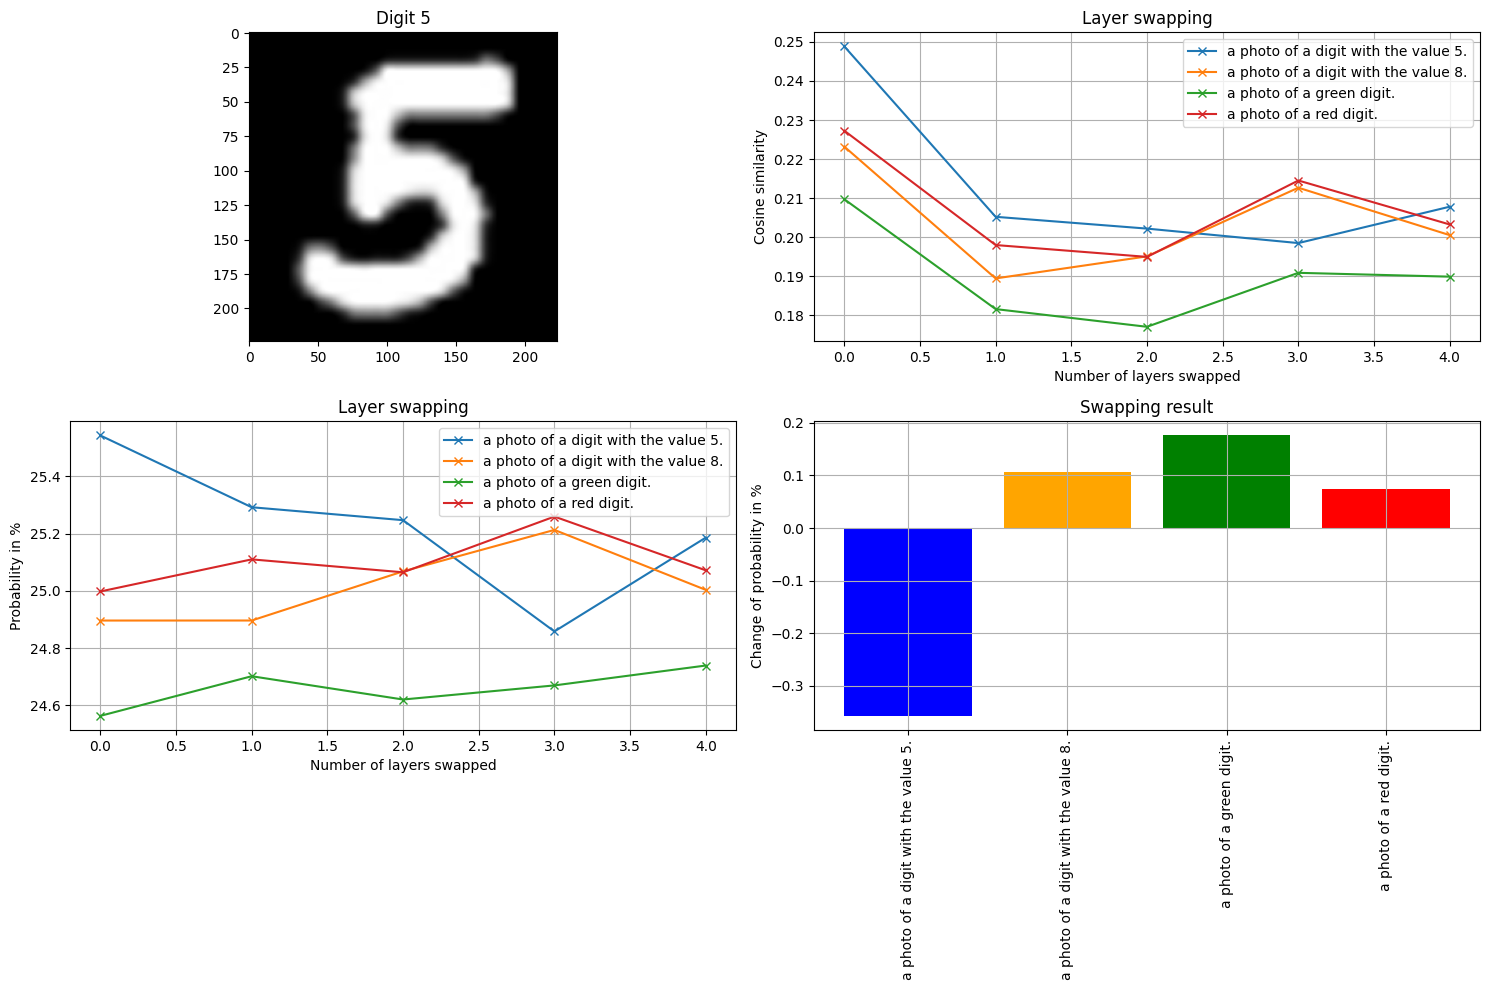

In [32]:
def display_layer_swapping_progress(img, ground_truth, cosine_similarities, captions):
    """
    Display image, cosine similarity and class probabilities over the number of swapped layers.
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0][0].imshow(img)
    axs[0][0].set_title(f"Digit {ground_truth[0].item()}")
    
    axs[0][1].plot(cosine_similarities, 'x-', label=captions)
    axs[0][1].set_title("Layer swapping")
    axs[0][1].set_xlabel("Number of layers swapped")
    axs[0][1].set_ylabel("Cosine similarity")
    axs[0][1].legend()
    axs[0][1].grid()

    axs[1][0].plot(100.0 * torch.tensor(cosine_similarities, dtype=torch.float32).softmax(dim=1), 'x-', label=captions)
    axs[1][0].set_title("Layer swapping")
    axs[1][0].set_xlabel("Number of layers swapped")
    axs[1][0].set_ylabel("Probability in %")
    axs[1][0].legend()
    axs[1][0].grid()
    
    probs = 100.0 * torch.tensor(cosine_similarities, dtype=torch.float32).softmax(dim=1)
    rel_change_probs = probs[-1,:] - probs[0,:]
    axs[1][1].bar(captions, rel_change_probs, color=['blue', 'orange', 'green', 'red'])
    axs[1][1].set_title("Swapping result")
    axs[1][1].set_ylabel("Change of probability in %")
    plt.xticks(rotation=90)       
    axs[1][1].grid()

    plt.tight_layout()
    plt.show()

display_layer_swapping_progress(clip_preprocess_inverse(img[0].unsqueeze(dim=0).cpu(), clip_preprocess),
                                label,
                                cos_sim[:, :cos_sim.shape[1] // DATASET_BATCH_SIZE].T,
                                captions)


In [33]:
# setup captions
captions = ["a photo of a digit with the value 5.",
            "a photo of a digit with the value 8.",
            "a photo of a green digit.",
            "a photo of a red digit."]

In [34]:
def caption_idx_to_dataset_idx(caption_idx):
    """
    Transforms the caption indices to the matching numbers from the dataset.
    """
    caption_idx[caption_idx == 0] = 5 # digit with value 5
    caption_idx[caption_idx == 1] = 8 # digit with value 8
    caption_idx[caption_idx == 2] = 1 # green digit
    caption_idx[caption_idx == 3] = 0 # red digit

In [35]:
import copy

def switch_values(vector, options):
    """
    Expects a tensor with two unique values. Switches each and every value with
    the second option.
    """
    
    # data preparation
    vector_cpy = copy.deepcopy(vector.flatten())
    vector_cpy_uniques = vector_cpy.unique()
    two_unique_values = vector_cpy_uniques.size()[0] == 2

    # modify tensor
    if two_unique_values:
        # swap two unique values
        vector_cpy[vector_cpy==vector_cpy_uniques[0]] = 99
        vector_cpy[vector_cpy==vector_cpy_uniques[1]] = vector_cpy_uniques[0]
        vector_cpy[vector_cpy==99] = vector_cpy_uniques[1]
    else:
        # assume one unique value
        if vector_cpy_uniques.size()[0] != 1:
            raise Exception("Oops.. Too many unique values!")
        
        # flip unique value
        vector_cpy[vector_cpy==vector_cpy_uniques] = options[options != vector_cpy_uniques]
        
    return vector_cpy.flatten()

In [36]:
def compute_accuracy(similarities, ground_truth_labels, color_labels, corrects={}):
    
    # setup options
    shape_options = torch.tensor([5, 8])
    color_options = torch.tensor([0, 1])

    # original clip cosine similarities and one per layer
    length = similarities.shape[1] // DATASET_BATCH_SIZE # first element is performance of CLIP and then the performance of the n-swapped layers (usually 4 CLIP layers), hence length=5
     
    # original CLIP cosine simimilarity (Before swapping layers)
    before_swap_predictions = similarities[:, ::length]
    prediction = before_swap_predictions.argmax(0)
    caption_idx_to_dataset_idx(prediction)
    corrects['CLIP correct shape'] += (prediction == ground_truth_labels.flatten().numpy()).sum()
    corrects['CLIP correct color'] += (prediction == color_labels.numpy()).sum()
    corrects['CLIP wrong shape'] += (prediction == switch_values(ground_truth_labels, shape_options).numpy()).sum()
    corrects['CLIP wrong color'] += (prediction == switch_values(color_labels, color_options).numpy()).sum()
    corrects['Total'] += prediction.shape[0]
    
    # absolute cosine simimilarity after all swaps
    after_swap_predictions = similarities[:,length-1:][:,::length]
    prediction = after_swap_predictions.argmax(0)
    caption_idx_to_dataset_idx(prediction)
    corrects['After swap absolute correct shape'] += (prediction == ground_truth_labels.flatten().numpy()).sum()
    corrects['After swap absolute correct color'] += (prediction == color_labels.numpy()).sum()
    corrects['After swap absolute wrong shape'] += (prediction == switch_values(ground_truth_labels, shape_options).numpy()).sum()
    corrects['After swap absolute wrong color'] += (prediction == switch_values(color_labels, color_options).numpy()).sum()
    
    # relative cosine simimilarity between original and after all swaps
    relative_after_swap_predictions = after_swap_predictions - before_swap_predictions
    prediction = relative_after_swap_predictions.argmax(0)
    caption_idx_to_dataset_idx(prediction)
    corrects['After swap relative correct shape'] += (prediction == ground_truth_labels.flatten().numpy()).sum()
    corrects['After swap relative correct color'] += (prediction == color_labels.numpy()).sum()
    corrects['After swap relative wrong shape'] += (prediction == switch_values(ground_truth_labels, shape_options).numpy()).sum()
    corrects['After swap relative wrong color'] += (prediction == switch_values(color_labels, color_options).numpy()).sum()
    
    return corrects

In [37]:
# restore CLIP model
clip_model, clip_preprocess, clip_layers = setup_clip(USE_ALL_CLIP_LAYERS,
                                                      LIMIT_NR_LAYERS,
                                                      print_config=False)

# setup performance dict
performance = {'CLIP correct shape' : 0,
                'CLIP correct color' : 0,
                'CLIP wrong shape' : 0,
                'CLIP wrong color' : 0,
                'After swap absolute correct shape' : 0,
                'After swap absolute correct color' : 0,
                'After swap absolute wrong shape' : 0,
                'After swap absolute wrong color' : 0,
                'After swap relative correct shape' : 0,
                'After swap relative correct color' : 0,
                'After swap relative wrong shape' : 0,
                'After swap relative wrong color' : 0,
                'Total' : 0}

for data in data_loader:
    # img, ground_truth_label, low_high_label, color_label
    image = data[0].to(device)
    ground_truth_label = data[1]
    color_label = data[3]
    
    # ~9 seconds for one batch
    _, cos_sim = swap_layers(image, table,
                            standalone_model, standalone_layers,
                            clip_model, clip_layers,
                            standalone_statistics, clip_statistics,
                            standalone_idxs, captions)
    
    # compute running accuracy
    performance = compute_accuracy(cos_sim, ground_truth_label, color_label, performance)

In [38]:
def print_performance(performance):
    """
    Display performance of original CLIP before swapping and after swapping.
    The number of correct and wrong top-1 accuracies for the features shape and colors are tracked.
    """
    
    print(f"CLIP before swapping - Correct shape: {100.0 * performance['CLIP correct shape'] / performance['Total']}%")
    print(f"CLIP before swapping - Correct color: {100.0 * performance['CLIP correct color'] / performance['Total']}%")
    print(f"CLIP before swapping - Wrong shape: {100.0 * performance['CLIP wrong shape'] / performance['Total']}%")
    print(f"CLIP before swapping - Wrong color: {100.0 * performance['CLIP wrong color'] / performance['Total']}%\n")
    
    print(f"CLIP after swapping - Correct shape absolute: {100.0 * performance['After swap absolute correct shape'] / performance['Total']}%")
    print(f"CLIP after swapping - Correct color absolute: {100.0 * performance['After swap absolute correct color'] / performance['Total']}%")
    print(f"CLIP after swapping - Wrong shape absolute: {100.0 * performance['After swap absolute wrong shape'] / performance['Total']}%")
    print(f"CLIP after swapping - Wrong color absolute: {100.0 * performance['After swap absolute wrong color'] / performance['Total']}%\n")
    
    print(f"CLIP after swapping - Correct shape relative: {100.0 * performance['After swap relative correct shape'] / performance['Total']}%")
    print(f"CLIP after swapping - Correct color relative: {100.0 * performance['After swap relative correct color'] / performance['Total']}%")
    print(f"CLIP after swapping - Wrong shape relative: {100.0 * performance['After swap relative wrong shape'] / performance['Total']}%")
    print(f"CLIP after swapping - Wrong color relative: {100.0 * performance['After swap relative wrong color'] / performance['Total']}%")
    
print_performance(performance)

CLIP before swapping - Correct shape: 32.7%
CLIP before swapping - Correct color: 33.4%
CLIP before swapping - Wrong shape: 33.4%
CLIP before swapping - Wrong color: 0.5%

CLIP after swapping - Correct shape absolute: 35.1%
CLIP after swapping - Correct color absolute: 32.95%
CLIP after swapping - Wrong shape absolute: 31.7%
CLIP after swapping - Wrong color absolute: 0.25%

CLIP after swapping - Correct shape relative: 34.55%
CLIP after swapping - Correct color relative: 18.9%
CLIP after swapping - Wrong shape relative: 31.1%
CLIP after swapping - Wrong color relative: 15.45%
